In [22]:

import pickle
import os
import sys
import sys
import GPUtil  # You already have this imported
from pynvml import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import torch
import seaborn as sns
from sklearn.preprocessing import Normalizer
import joblib
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior, PosteriorSamples

from sbi.utils.user_input_checks import process_prior

sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params_1P import plot_uvlf, plot_colour
from setup_params_SB import *
# from setup_params import *
from priors_SB import initialise_priors_SB28
from variables_config_28 import uvlf_limits, n_bins_lf, colour_limits, n_bins_colour

# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = "IllustrisTNG"
spec_type = "attenuated"
sps = "BC03"
snap = ["044"]
bands = "all" # or just GALEX?

colours = True  
luminosity_functions = True
name = f"{model}_{bands}_{sps}_{spec_type}_{n_bins_lf}_{n_bins_colour}"

snap_str = str(snap[0])

cam = camels(model=model, sim_set='SB28')

if colours and not luminosity_functions:
    model_out_dir = os.path.join("/disk/xray15/aem2/data/28pams/SB/IllustrisTNG/models/colours_only/", f"{snap_str}")
    plots_out_dir = os.path.join("/disk/xray15/aem2/plots/28pams/SB/IllustrisTNG/test/sbi_plots/colours_only/", f"{snap_str}")
    
elif luminosity_functions and not colours:
    model_out_dir = os.path.join("/disk/xray15/aem2/data/28pams/SB/IllustrisTNG/models/lf_only/", f"{snap_str}")
    plots_out_dir = os.path.join("/disk/xray15/aem2/plots/28pams/SB/IllustrisTNG/test/sbi_plots/lf_only/", f"{snap_str}")

elif colours and luminosity_functions:
    model_out_dir = os.path.join("/disk/xray15/aem2/data/28pams/SB/IllustrisTNG/models/colours_lfs/", f"{snap_str}")
    plots_out_dir = os.path.join("/disk/xray15/aem2/plots/28pams/SB/IllustrisTNG/test/sbi_plots/colours_lfs/", f"{snap_str}")

# You might want to add an else for safety:
else:
    raise ValueError("At least one of colours or luminosity_functions must be True")

# number of astronomy and cosmology parameters we want to use.
num_asco_pams = 28


print("Saving model in ", model_out_dir)
print("Saving plots in ", plots_out_dir)


Saving model in  /disk/xray15/aem2/data/28pams/SB/IllustrisTNG/models/colours_lfs/044
Saving plots in  /disk/xray15/aem2/plots/28pams/SB/IllustrisTNG/test/sbi_plots/colours_lfs/044


In [ ]:
# # Add this function at the start, before any GPU operations
# def select_least_used_gpu():
#     try:
#         # Initialize NVIDIA management library
#         nvmlInit()
        
#         # Get number of GPUs
#         deviceCount = nvmlDeviceGetCount()
#         gpu_memory_used = []
        
#         # Check memory usage for each GPU
#         for i in range(deviceCount):
#             handle = nvmlDeviceGetHandleByIndex(i)
#             info = nvmlDeviceGetMemoryInfo(handle)
#             gpu_memory_used.append((i, info.used))
        
#         # Sort by memory usage and get GPU with least memory used
#         least_used_gpu = sorted(gpu_memory_used, key=lambda x: x[1])[0][0]
        
#         # Set CUDA device
#         torch.cuda.set_device(least_used_gpu)
#         print(f"Selected GPU {least_used_gpu} with {gpu_memory_used[least_used_gpu][1]/1024**2:.0f}MB used")
        
#         return least_used_gpu
    
#     except Exception as e:
#         print(f"Error selecting GPU: {e}")
#         return 0  # Default to first GPU if there's an error

# # Add this right after your imports, before any GPU operations
# # Select GPU and set device
# gpu_id = select_least_used_gpu()
# os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
# device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")

# # The rest of your code remains the same, but remove or comment out your original device line:
# # device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
cam = camels(model=model, sim_set='SB28')
cam.labels

['Omega0',
 'sigma8',
 'WindEnergyIn1e51erg',
 'RadioFeedbackFactor',
 'VariableWindVelFactor',
 'RadioFeedbackReiorientationFactor',
 'OmegaBaryon',
 'HubbleParam',
 'n_s',
 'MaxSfrTimescale',
 'FactorForSofterEQS',
 'IMFslope',
 'SNII_MinMass_Msun',
 'ThermalWindFraction',
 'VariableWindSpecMomentum',
 'WindFreeTravelDensFac',
 'MinWindVel',
 'WindEnergyReductionFactor',
 'WindEnergyReductionMetallicity',
 'WindEnergyReductionExponent',
 'WindDumpFactor',
 'SeedBlackHoleMass',
 'BlackHoleAccretionFactor',
 'BlackHoleEddingtonFactor',
 'BlackHoleFeedbackFactor',
 'BlackHoleRadiativeEfficiency',
 'QuasarThreshold',
 'QuasarThresholdPower']

In [24]:
cam.labels[0:num_asco_pams]

['Omega0',
 'sigma8',
 'WindEnergyIn1e51erg',
 'RadioFeedbackFactor',
 'VariableWindVelFactor',
 'RadioFeedbackReiorientationFactor',
 'OmegaBaryon',
 'HubbleParam',
 'n_s',
 'MaxSfrTimescale',
 'FactorForSofterEQS',
 'IMFslope',
 'SNII_MinMass_Msun',
 'ThermalWindFraction',
 'VariableWindSpecMomentum',
 'WindFreeTravelDensFac',
 'MinWindVel',
 'WindEnergyReductionFactor',
 'WindEnergyReductionMetallicity',
 'WindEnergyReductionExponent',
 'WindDumpFactor',
 'SeedBlackHoleMass',
 'BlackHoleAccretionFactor',
 'BlackHoleEddingtonFactor',
 'BlackHoleFeedbackFactor',
 'BlackHoleRadiativeEfficiency',
 'QuasarThreshold',
 'QuasarThresholdPower']

### Alice version of sbi for 29 pams, using dfs


# Get priors:

In [25]:

# prior values come from this:
df_info = pd.read_csv("/disk/xray15/aem2/data/28pams/Info_IllustrisTNG_L25n256_28params.txt")
df_info = df_info[0:num_asco_pams] # may be able to do feature /param selection more specifically later (get rid of agn ones)
df_info

,ParamName,AbsMaxDiff,LogFlag,FiducialVal,MinVal,MaxVal,Description
0,Omega0,0.20,0,0.30000,0.100000,0.500000,OmegaMatter
1,sigma8,0.20,0,0.80000,0.600000,1.000000,sigma8
2,WindEnergyIn1e51erg,4.00,1,3.60000,0.900000,14.400000,ASN1 - galactic winds energy
3,RadioFeedbackFactor,4.00,1,1.00000,0.250000,4.000000,AAGN1 - AGN FB kinetic mode energy
4,VariableWindVelFactor,2.00,1,7.40000,3.700000,14.800000,ASN2 - galactic winds speed
5,RadioFeedbackReiorientationFactor,2.00,1,20.00000,10.000000,40.000000,AAGN2 - AGN FB kinetic mode burstiness
6,OmegaBaryon,0.02,0,0.04900,0.029000,0.069000,OmegaBaryon
7,HubbleParam,0.20,0,0.67110,0.471100,0.871100,Hubble parameter
8,n_s,0.20,0,0.96240,0.762400,1.162400,power spectrum spectral index
9,MaxSfrTimescale,2.00,1,2.27000,1.135000,4.540000,gas consumption timescale


In [26]:

# get the priors and data
prior = initialise_priors_SB28(
    df=df_info, 
    device=device,
    astro=True,
    dust=False  # no dust for testing. set to False to only get the 28 model parameters.
    # with dust = True, prior has 32 dimensions (28 parameters + 4 dust parameters) 
)


processing Omega0:
processing Omega0 is linear with min 0.1 and max 0.5:
processing sigma8:
processing sigma8 is linear with min 0.6 and max 1.0:
processing WindEnergyIn1e51erg:
processing WindEnergyIn1e51erg is logarithmic with min 0.9 and max 14.4:
processing RadioFeedbackFactor:
processing RadioFeedbackFactor is logarithmic with min 0.25 and max 4.0:
processing VariableWindVelFactor:
processing VariableWindVelFactor is logarithmic with min 3.7 and max 14.8:
processing RadioFeedbackReiorientationFactor:
processing RadioFeedbackReiorientationFactor is logarithmic with min 10.0 and max 40.0:
processing OmegaBaryon:
processing OmegaBaryon is linear with min 0.029 and max 0.069:
processing HubbleParam:
processing HubbleParam is linear with min 0.4711 and max 0.8711:
processing n_s:
processing n_s is linear with min 0.7624 and max 1.1624:
processing MaxSfrTimescale:
processing MaxSfrTimescale is logarithmic with min 1.135 and max 4.54:
processing FactorForSofterEQS:
processing FactorForSo

/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 28 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(


In [27]:

if __name__ == "__main__":
    theta, x = get_theta_x_SB(
        photo_dir=f"/disk/xray15/aem2/data/28pams/SB/IllustrisTNG/photometry", #/alice_galex.h5",
        spec_type=spec_type,
        model=model,
        snap=snap,
        sps=sps,
        n_bins_lf=13,
        n_bins_colour=n_bins_colour,
        colours=colours,
        luminosity_functions=luminosity_functions,
        device=device,
    )
    print(theta.shape, x.shape)


torch.Size([2048, 28]) (2048, 36)


# Normalise data

In [7]:
x_all = np.array([np.hstack(_x) for _x in x])

norm = Normalizer()
x_all = torch.tensor(
    norm.fit_transform(X=x_all),
    # x_all,
    dtype=torch.float32,
    device=device, 
)

# make test mask
test_mask = create_test_mask() # 10% testing
# train_mask = ~test_mask # 90% for training

# to see tests on normalising look at /disk/xray15/aem2/camels/proj1/LH/SBI/sbi_test_LH_normalise_test.ipynb


Total simulations: 2048
Test set size: 203
Training set size: 1845
Test fraction: 0.099


# Define training parameters

In [8]:

# # Network architecture improvements
hidden_features = 70  # Chris HF =60
num_transforms = 4    # Chris NT = 4
num_nets = 3 # Chris nn = 2, current best is 3
# # num_bins = 10 # spline bins, this is default in sbi package anyway.

# best model so far:
# batch5_lr0.0005_epochs20_max_num_epochs100_validation_fraction0.1_clip_max_norm1.8_h70_t4_nn3
train_args = {
    "training_batch_size": 5, # Chris BS = 4
    "learning_rate": 5e-4,      # Chris LR =  5e-4,     
    "stop_after_epochs": 10,     # Chris stop epochs = unknown, 20 is best currently
    "max_num_epochs": 50,        # Chris max epochs = unknown, 100 is best currently
    "clip_max_norm": 1.8,       # try best with clipping at lower val (default is 5 in sbi)
    "validation_fraction": 0.1, # Keep current validation split
    "use_combined_loss": True,
    "show_train_summary": True,
    "dataloader_kwargs": {
        "num_workers": 0,
        "pin_memory": False
    }
}


# Define config string for saving

In [9]:

# Create config string for filenames
config_str = (f"batch{train_args['training_batch_size']}_"
             f"lr{train_args['learning_rate']}_"
             f"epochs{train_args['stop_after_epochs']}_"
             f"max_num_epochs{train_args['max_num_epochs']}_"
             f"validation_fraction{train_args['validation_fraction']}_"
             f"clip_max_norm{train_args['clip_max_norm']}_"
             f"h{hidden_features}_t{num_transforms}_nn{num_nets}")

# Create a new directory with the config string
config_plots_dir = os.path.join(plots_out_dir, config_str)
config_model_dir = os.path.join(model_out_dir, config_str)
os.makedirs(config_plots_dir, exist_ok=True)
os.makedirs(config_model_dir, exist_ok=True)
print("Model will be saved to: ", config_model_dir)
print("Plots will be saved to: ", config_plots_dir)

# save normaliser to config dir.
joblib.dump(norm, os.path.join(config_model_dir, f'data_normaliser_{name}_scaler.save'))


Model will be saved to:  /disk/xray15/aem2/data/28pams/SB/IllustrisTNG/models/colours_lfs/044/batch5_lr0.0005_epochs10_max_num_epochs50_validation_fraction0.1_clip_max_norm1.8_h70_t4_nn3
Plots will be saved to:  /disk/xray15/aem2/plots/28pams/SB/IllustrisTNG/test/sbi_plots/colours_lfs/044/batch5_lr0.0005_epochs10_max_num_epochs50_validation_fraction0.1_clip_max_norm1.8_h70_t4_nn3


['/disk/xray15/aem2/data/28pams/SB/IllustrisTNG/models/colours_lfs/044/batch5_lr0.0005_epochs10_max_num_epochs50_validation_fraction0.1_clip_max_norm1.8_h70_t4_nn3/data_normaliser_IllustrisTNG_all_BC03_attenuated_13_13_scaler.save']

# Run NN

In [10]:

# Increase ensemble size and capacity slightly
nets = [
    ili.utils.load_nde_sbi(
        engine="NPE",
        model="nsf", 
        hidden_features=hidden_features,      # Reduce further for better σ8 and ASN1/2
        num_transforms=num_transforms,        # Reduce transforms for simpler model
    ) for _ in range(num_nets)         # Keep ensemble size
]

# Keep the existing loader setup with scaled data
loader = NumpyLoader(
    x=x_all[~test_mask],
    theta=torch.tensor(theta[~test_mask, :], device=device)
)


runner = InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=config_model_dir,
    name=name,
)

print('Training with ', config_str)

posterior_ensemble, summaries = runner(loader=loader)


/tmp/ipykernel_3092980/148946216.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta=torch.tensor(theta[~test_mask, :], device=device)
INFO:root:MODEL INFERENCE CLASS: NPE


Training with  batch5_lr0.0005_epochs10_max_num_epochs50_validation_fraction0.1_clip_max_norm1.8_h70_t4_nn3


/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 3.


 Training neural network. Epochs trained: 18

INFO:root:Training model 2 / 3.


 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -0.7948
        -------------------------
        
 Training neural network. Epochs trained: 17

INFO:root:Training model 3 / 3.


 Neural network successfully converged after 18 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 18
        Best validation performance: -1.3841
        -------------------------
        
 Training neural network. Epochs trained: 18

/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 1160.4946813583374 seconds to train models.
INFO:root:Saving model to /disk/xray15/aem2/data/28pams/SB/IllustrisTNG/models/colours_lfs/044/batch5_lr0.0005_epochs10_max_num_epochs50_validation_fraction0.1_clip_max_norm1.8_h70_t4_nn3


 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -1.2113
        -------------------------
        


# Save model

In [11]:
# Create comprehensive results dictionary
results = {
    "posterior_ensemble": posterior_ensemble,
    "summaries": summaries,
    "config": {
        "hidden_features": hidden_features,
        "num_transforms": num_transforms,
        "num_nets": num_nets,
        "train_args": train_args,
        "config_str": config_str
    }
}

# Save the complete results in the config directory

# Save using pickle for the complete object
with open(os.path.join(config_model_dir, f"{name}_complete.pkl"), "wb") as f:
    pickle.dump(results, f)

# Also save the posterior ensemble using torch.save for compatibility
torch.save(posterior_ensemble, os.path.join(config_model_dir, f"{name}_posterior.pkl"))

# Copy or move the summary file if it was created in the original directory
summary_file = os.path.join(model_out_dir, f"{name}summary.json")
if os.path.exists(summary_file):
    import shutil
    shutil.copy2(summary_file, os.path.join(config_model_dir, f"{name}summary.json"))
    
# Path to the complete model file
complete_model_path = os.path.join(config_model_dir, f'{name}_complete.pkl')
posterior_ensemble_path = os.path.join(config_model_dir, f'{name}_posterior.pkl')
print(f"Complete model saved to: ", complete_model_path)
print(f"Posterior ensemble saved to:",  posterior_ensemble_path)

Complete model saved to:  /disk/xray15/aem2/data/28pams/SB/IllustrisTNG/models/colours_lfs/044/batch5_lr0.0005_epochs10_max_num_epochs50_validation_fraction0.1_clip_max_norm1.8_h70_t4_nn3/IllustrisTNG_all_BC03_attenuated_13_13_complete.pkl
Posterior ensemble saved to: /disk/xray15/aem2/data/28pams/SB/IllustrisTNG/models/colours_lfs/044/batch5_lr0.0005_epochs10_max_num_epochs50_validation_fraction0.1_clip_max_norm1.8_h70_t4_nn3/IllustrisTNG_all_BC03_attenuated_13_13_posterior.pkl


In [12]:

# Try to load the file
try:
    with open(complete_model_path, 'rb') as f:
        complete_model = pickle.load(f)
    
    # Print the structure of the object
    print("Type of complete_model:", type(complete_model))
    
    if isinstance(complete_model, dict):
        print("\nKeys in complete_model:", complete_model.keys())
        
        # Check for validation metrics
        if 'summaries' in complete_model:
            print("\nType of summaries:", type(complete_model['summaries']))
            
            if isinstance(complete_model['summaries'], list):
                print("\nNumber of items in summaries:", len(complete_model['summaries']))
                print("\nKeys in first summary item:", complete_model['summaries'][0].keys())
                
                if 'validation_log_probs' in complete_model['summaries'][0]:
                    val_probs = complete_model['summaries'][0]['validation_log_probs']
                    print("\nValidation log probabilities:")
                    print(f"Min: {min(val_probs)}, Max: {max(val_probs)}")
                    print(f"Best epoch: {val_probs.index(max(val_probs))}")
                    
                    # Print a few values
                    print("\nFirst few validation log probabilities:")
                    for i, prob in enumerate(val_probs[:5]):
                        print(f"Epoch {i+1}: {prob}")
                    
                    print("\nLast few validation log probabilities:")
                    for i, prob in enumerate(val_probs[-5:]):
                        print(f"Epoch {len(val_probs)-4+i}: {prob}")
except Exception as e:
    print(f"Error loading or processing the file: {e}")

Type of complete_model: <class 'dict'>

Keys in complete_model: dict_keys(['posterior_ensemble', 'summaries', 'config'])

Type of summaries: <class 'list'>

Number of items in summaries: 3

Keys in first summary item: dict_keys(['epochs_trained', 'best_validation_log_prob', 'validation_log_probs', 'training_log_probs', 'epoch_durations_sec'])

Validation log probabilities:
Min: -3.9519789515314874, Max: -0.794784875818201
Best epoch: 8

First few validation log probabilities:
Epoch 1: -3.9519789515314874
Epoch 2: -2.4965209857837576
Epoch 3: -1.9753169394828178
Epoch 4: -1.572573945328996
Epoch 5: -1.237886954642631

Last few validation log probabilities:
Epoch 15: -2.007605712478225
Epoch 16: -1.843366695094753
Epoch 17: -2.280263849206873
Epoch 18: -2.232639405534074
Epoch 19: -2.4757522170608106


In [13]:
x_test = x_all[test_mask]
theta_test = theta[test_mask].cpu().numpy()

In [14]:
type(x_test)

torch.Tensor

In [15]:
type(theta_test)

numpy.ndarray

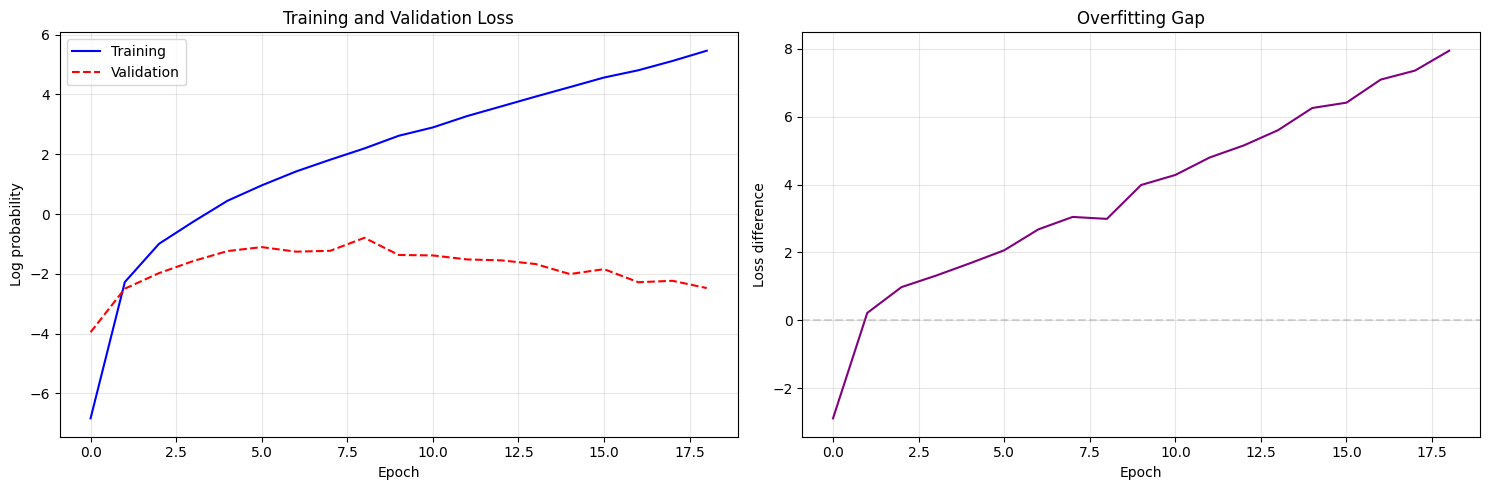

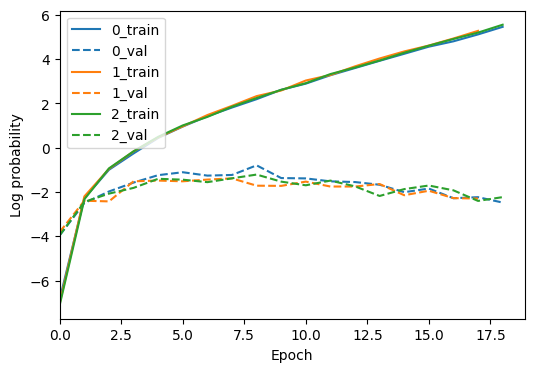

  0%|          | 0/203 [00:00<?, ?it/s]/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(
100%|██████████| 203/203 [00:43<00:00,  4.71it/s]
INFO:root:Mean logprob: -1.0029e+01Median logprob: -9.0526e+00
100%|██████████| 100/100 [00:04<00:00, 20.35it/s]


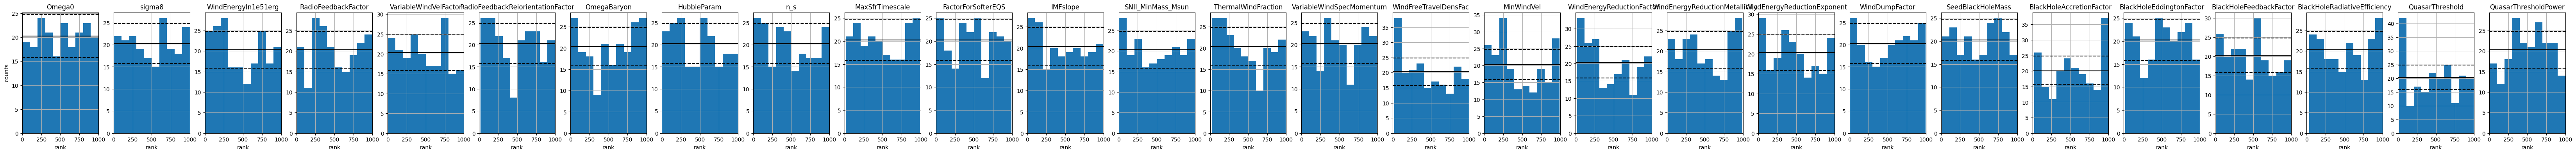

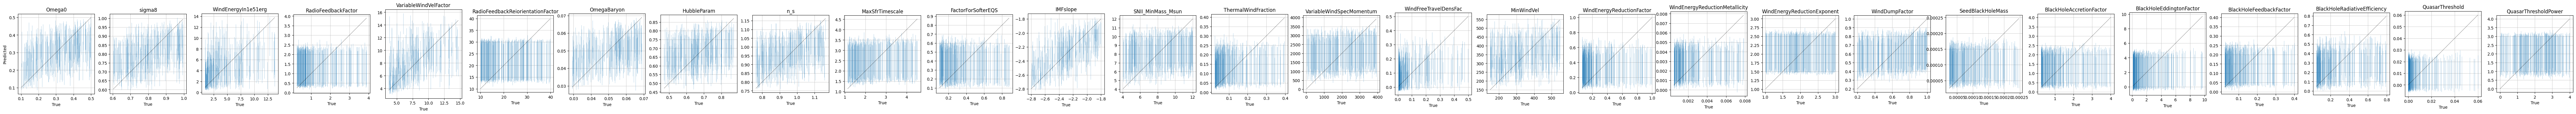

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


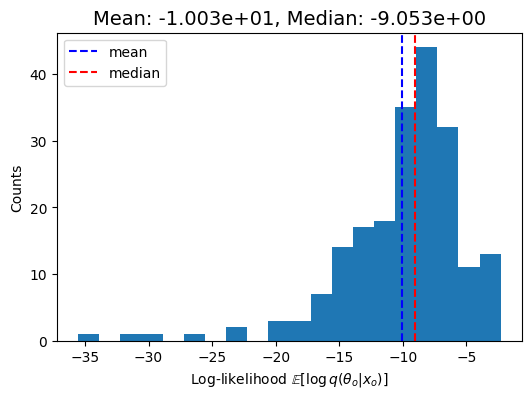

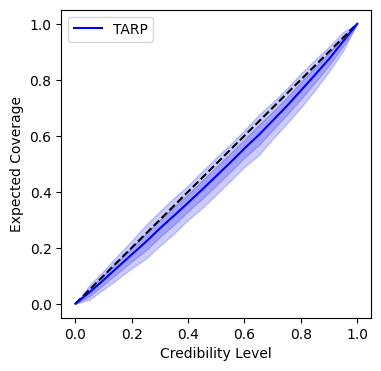

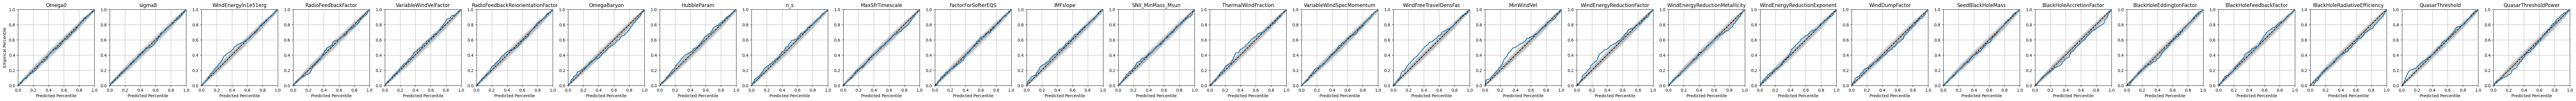

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

All plots saved in: /disk/xray15/aem2/plots/28pams/SB/IllustrisTNG/test/sbi_plots/colours_lfs/044/batch5_lr0.0005_epochs10_max_num_epochs50_validation_fraction0.1_clip_max_norm1.8_h70_t4_nn3


In [16]:


# First plot: Training diagnostics with two subplots
def plot_training_diagnostics(summaries):
    """Plot training diagnostics with loss and overfitting gap"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    train_losses = summaries[0]['training_log_probs']
    val_losses = summaries[0]['validation_log_probs']
    epochs = range(len(train_losses))
    
    ax1.plot(epochs, train_losses, '-', label='Training', color='blue')
    ax1.plot(epochs, val_losses, '--', label='Validation', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Log probability')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Overfitting gap
    gap = np.array(train_losses) - np.array(val_losses)
    ax2.plot(epochs, gap, '-', color='purple')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss difference')
    ax2.set_title('Overfitting Gap')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Second plot: Ensemble training curves
def plot_ensemble_training(summaries):
    """Plot training curves for each ensemble member"""
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    c = list(mcolors.TABLEAU_COLORS)
    for i, m in enumerate(summaries):
        ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
        ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
    ax.set_xlim(0)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log probability')
    ax.legend()
    return fig

# Save training plots in the new directory
fig1 = plot_training_diagnostics(summaries)
plt.savefig(os.path.join(config_plots_dir, f'training_analysis_{name}.png'),
            dpi=300, bbox_inches='tight')
plt.show()
plt.close()

fig2 = plot_ensemble_training(summaries)
plt.savefig(os.path.join(config_plots_dir, f'ensemble_training_{name}.png'),
            dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Create metric and get plots
metric = PosteriorCoverage(
    num_samples=int(1000),
    sample_method='direct',
    labels=cam.labels, #[0:num_asco_pams],
    plot_list=["coverage", "histogram", "predictions", "tarp", "logprob"], 
)

# Create metric and get plots
metric = PosteriorCoverage(
    num_samples=int(1000),
    sample_method='direct',
    labels=cam.labels, #[0:num_asco_pams],
    plot_list=["coverage", "histogram", "predictions", "tarp", "logprob"], 
)

# Get the metric plots
plot_types = ["coverage", "histogram", "predictions", "tarp", "logprob"]
figs = metric(
    posterior=posterior_ensemble,
    x=x_test,
    theta=theta_test,
    signature=f"coverage_{name}_{config_str}_"
)

# Save and display the metric plots
def save_and_display_metric_plots(figs, plot_types, config_plots_dir, name):
    for fig, plot_type in zip(figs, plot_types):
        if fig is not None:
            # Ensure the figure is a matplotlib figure
            if hasattr(fig, 'savefig'):
                plot_path = os.path.join(config_plots_dir, f'{plot_type}_{name}.png')
                fig.savefig(plot_path, dpi=300, bbox_inches='tight')
                plt.figure(fig.number)  # Make this figure the current figure
                plt.show()  # Display the figure
                plt.close(fig)  # Close the figure to free up memory
            else:
                print(f"Warning: {plot_type} figure is not a standard matplotlib figure")

# Save and display the metric plots
save_and_display_metric_plots(figs, plot_types, config_plots_dir, name)

print(f"All plots saved in: {config_plots_dir}")

# Errors / Validation metrics

In [17]:
# first try tweaking the time and then try tweaking the model a little and making it simpler and leting it run for longer..

In [18]:

# Create the metric object
metric = PosteriorSamples(
    num_samples=int(1e4),  # 10,000 samples like your supervisor used
    sample_method="direct",
)

# Now use it to get posterior samples
psamps = metric(
    posterior=posterior_ensemble,
    x=x_all[test_mask],
    theta=theta[test_mask],
)

# Calculate the percentiles and metrics
perc = np.percentile(psamps, q=[16, 50, 84], axis=0)

# Calculate RMSE, epsilon, R², and χ²
rmse = np.sqrt(
    np.sum((theta.cpu().numpy()[test_mask, :] - perc[1, :, :])**2, axis=0) / 
    np.sum(test_mask)
)

# Mean relative error (epsilon)
mre = np.sum(
    ((perc[2, :, :] - perc[0, :, :]) / 2) / perc[1, :, :], axis=0
) / np.sum(test_mask)

# R-squared
theta_hat = np.sum(theta.cpu().numpy()[test_mask, :], axis=0) / np.sum(test_mask)
r2 = 1 - np.sum(
    (theta.cpu().numpy()[test_mask, :] - perc[1, :, :])**2, axis=0
) / np.sum(
    (theta.cpu().numpy()[test_mask, :] - theta_hat)**2, axis=0
)

# Chi-squared
chi2 = np.sum(
    (theta.cpu().numpy()[test_mask, :] - perc[1, :, :])**2 /
    ((perc[2, :, :] - perc[0, :, :]) / 2)**2, axis=0
) / np.sum(test_mask)

# Print results for each parameter
for i, param in enumerate(cam.labels[0:num_asco_pams]):
    print(f"\nMetrics for {param}:")
    print(f"RMSE: {rmse[i]:.4f}")
    print(f"Epsilon: {mre[i]:.4f}")
    print(f"R²: {r2[i]:.4f}")
    print(f"χ²: {chi2[i]:.4f}")


# Define the file path
metrics_file = os.path.join(config_plots_dir, f'metrics_{name}.txt')

# Write metrics to the file
with open(metrics_file, 'w') as f:
    for i, param in enumerate(cam.labels[0:num_asco_pams]):
        f.write(f"\nMetrics for {param}:\n")
        f.write(f"RMSE: {rmse[i]:.4f}\n")
        f.write(f"Epsilon: {mre[i]:.4f}\n")
        f.write(f"R²: {r2[i]:.4f}\n")
        f.write(f"χ²: {chi2[i]:.4f}\n")

print(f"Metrics saved in: {metrics_file}")


100%|██████████| 203/203 [00:47<00:00,  4.31it/s]



Metrics for Omega0:
RMSE: 0.0944
Epsilon: 0.3629
R²: 0.3038
χ²: 0.8410

Metrics for sigma8:
RMSE: 0.0963
Epsilon: 0.1257
R²: 0.2556
χ²: 0.9675

Metrics for WindEnergyIn1e51erg:
RMSE: 3.1577
Epsilon: 0.6943
R²: 0.1507
χ²: 1.4356

Metrics for RadioFeedbackFactor:
RMSE: 1.0968
Epsilon: 1.0073
R²: -0.1109
χ²: 1.1591

Metrics for VariableWindVelFactor:
RMSE: 2.6264
Epsilon: 0.2787
R²: 0.2179
χ²: 1.7538

Metrics for RadioFeedbackReiorientationFactor:
RMSE: 8.6666
Epsilon: 0.4808
R²: -0.0131
χ²: 0.7784

Metrics for OmegaBaryon:
RMSE: 0.0106
Epsilon: 0.2137
R²: 0.2337
χ²: 1.1229

Metrics for HubbleParam:
RMSE: 0.1036
Epsilon: 0.1656
R²: 0.0870
χ²: 0.9494

Metrics for n_s:
RMSE: 0.0992
Epsilon: 0.1097
R²: 0.2690
χ²: 0.8937

Metrics for MaxSfrTimescale:
RMSE: 0.9900
Epsilon: 0.4539
R²: 0.0327
χ²: 0.8843

Metrics for FactorForSofterEQS:
RMSE: 0.2367
Epsilon: 0.8069
R²: -0.1342
χ²: 0.9757

Metrics for IMFslope:
RMSE: 0.2039
Epsilon: -0.0861
R²: 0.4757
χ²: 1.3223

Metrics for SNII_MinMass_Msun:
RM

# TESTING - commented out for now due to too much memory for 28 pam plots


In [19]:

# # Using variables already defined:
# # x_all, theta, test_mask, cam, posterior_ensemble

# def create_corner_plot(samples, true_values, param_names, figsize=(12, 12)):
#     """
#     Create a corner plot showing marginal and joint distributions of parameter samples.
    
#     Parameters:
#     -----------
#     samples : array-like
#         Array of shape (n_samples, n_params) containing posterior samples
#     true_values : array-like
#         Array of shape (n_params,) containing true parameter values
#     param_names : list
#         List of parameter names
#     figsize : tuple
#         Figure size
        
#     Returns:
#     --------
#     fig : matplotlib Figure
#         Corner plot figure
#     """
#     n_params = samples.shape[1]
#     fig, axes = plt.subplots(n_params, n_params, figsize=figsize)
    
#     # Set up the axes
#     for i in range(n_params):
#         for j in range(n_params):
#             if i < j:
#                 axes[i, j].set_visible(False)
#                 continue
                
#             if i == j:  # Diagonal: show marginal distributions
#                 axes[i, i].hist(samples[:, i], bins=25, alpha=0.7, density=True)
#                 axes[i, i].axvline(true_values[i], color='red', linestyle='--')
                
#                 # Only show x labels on bottom row
#                 if i < n_params - 1:
#                     axes[i, i].set_xticklabels([])
#                 else:
#                     axes[i, i].set_xlabel(param_names[i])
                
#                 # Remove y ticks for cleaner look
#                 axes[i, i].set_yticks([])
                
#             else:  # Off-diagonal: show joint distributions
#                 axes[i, j].scatter(samples[:, j], samples[:, i], alpha=0.1, s=1)
#                 axes[i, j].scatter(true_values[j], true_values[i], color='red', s=20, marker='*')
                
#                 # Only show x labels on bottom row
#                 if i < n_params - 1:
#                     axes[i, j].set_xticklabels([])
#                 else:
#                     axes[i, j].set_xlabel(param_names[j])
                
#                 # Only show y labels on leftmost column
#                 if j > 0:
#                     axes[i, j].set_yticklabels([])
#                 else:
#                     axes[i, j].set_ylabel(param_names[i])
    
#     plt.tight_layout()
#     return fig

# def plot_parameter_recovery(true_values, estimated_values, uncertainty_low, uncertainty_high, param_names):
#     """
#     Plot true vs. estimated parameter values with error bars.
    
#     Parameters:
#     -----------
#     true_values : array-like
#         Array of shape (n_samples, n_params) containing true parameter values
#     estimated_values : array-like
#         Array of shape (n_samples, n_params) containing estimated (median) values
#     uncertainty_low : array-like
#         Array of shape (n_samples, n_params) containing lower bounds
#     uncertainty_high : array-like
#         Array of shape (n_samples, n_params) containing upper bounds
#     param_names : list
#         List of parameter names
        
#     Returns:
#     --------
#     fig : matplotlib Figure
#         Parameter recovery plot
#     """
#     n_params = true_values.shape[1]
#     fig, axes = plt.subplots(1, n_params, figsize=(n_params*4, 4))
    
#     for i in range(n_params):
#         ax = axes[i]
        
#         # Calculate value ranges for equal aspect ratio
#         param_min = min(true_values[:, i].min(), estimated_values[:, i].min())
#         param_max = max(true_values[:, i].max(), estimated_values[:, i].max())
#         param_range = param_max - param_min
        
#         # Add some padding
#         param_min -= 0.1 * param_range
#         param_max += 0.1 * param_range
        
#         # Plot diagonal line
#         ax.plot([param_min, param_max], [param_min, param_max], 'k--', alpha=0.5)
        
#         # Plot error bars
#         for j in range(len(true_values)):
#             ax.errorbar(
#                 true_values[j, i], 
#                 estimated_values[j, i], 
#                 yerr=[[estimated_values[j, i] - uncertainty_low[j, i]], 
#                       [uncertainty_high[j, i] - estimated_values[j, i]]],
#                 fmt='o', alpha=0.5, color='blue', capsize=3
#             )
        
#         # Compute R² for this parameter
#         true_mean = np.mean(true_values[:, i])
#         ss_tot = np.sum((true_values[:, i] - true_mean)**2)
#         ss_res = np.sum((true_values[:, i] - estimated_values[:, i])**2)
#         r2 = 1 - (ss_res / ss_tot)
        
#         # Compute RMSE
#         rmse = np.sqrt(np.mean((true_values[:, i] - estimated_values[:, i])**2))
        
#         ax.set_xlabel(f'True {param_names[i]}')
#         ax.set_ylabel(f'Estimated {param_names[i]}')
#         ax.set_title(f'{param_names[i]}\nR² = {r2:.3f}, RMSE = {rmse:.3f}')
#         ax.set_aspect('equal')
#         ax.set_xlim(param_min, param_max)
#         ax.set_ylim(param_min, param_max)
        
#     plt.tight_layout()
#     return fig

# def visualize_test_set_results(config_plots_dir, name):
#     """
#     Generate and save visualization of test set results.
#     """
#     # Create directory if it doesn't exist
#     os.makedirs(config_plots_dir, exist_ok=True)
    
#     # Set up CUDA if available
#     device = "cuda" if torch.cuda.is_available() else "cpu"
    
#     # 1. Get posterior samples for test set
#     # Move tensors to CPU first
#     test_x_cpu = x_all[test_mask].cpu()
#     test_theta_cpu = theta[test_mask].cpu()
    
#     # Number of test samples to visualize (limit to avoid overwhelming plots)
#     n_test_samples = min(50, test_theta_cpu.shape[0])
    
#     # 2. Get predictions for each test sample
#     predictions = []
#     for i in range(n_test_samples):
#         # Get posterior samples for this test point
#         x_i = test_x_cpu[i].unsqueeze(0).to(device)  # Add batch dimension and move to device
#         samples = posterior_ensemble.sample((10000,), x=x_i).cpu().numpy()
#         predictions.append(samples)
    
#     # 3. Compute statistics from posterior samples
#     perc = []
#     for i in range(n_test_samples):
#         sample_perc = np.percentile(predictions[i], q=[16, 50, 84], axis=0)
#         perc.append(sample_perc)
    
#     # Convert to numpy arrays for easier processing
#     perc = np.array(perc)  # Shape: [n_test_samples, 3 (percentiles), n_params]
#     test_theta_np = test_theta_cpu.numpy()[:n_test_samples]
    
#     # commented out for now as too much memory
#     # # 4. Create corner plot for a few test examples
#     # for i in range(min(5, n_test_samples)):
#     #     fig = create_corner_plot(
#     #         samples=predictions[i], 
#     #         true_values=test_theta_np[i], 
#     #         param_names=cam.labels[0:num_asco_pams],
#     #         figsize=(15, 15)
#     #     )
#     #     fig.suptitle(f'Posterior Distribution for Test Sample {i+1}', fontsize=16)
#     #     fig.tight_layout(rect=[0, 0, 1, 0.97])  # Make room for suptitle
#     #     plt.savefig(os.path.join(config_plots_dir, f'corner_plot_test_sample_{i+1}_{name}.png'), 
#     #                dpi=300, bbox_inches='tight')
#     #     plt.show()
#     #     plt.close(fig)
    
#     # 5. Create parameter recovery plot
#     medians = perc[:, 1, :]  # Shape: [n_test_samples, n_params]
#     lower_bounds = perc[:, 0, :]
#     upper_bounds = perc[:, 2, :]
    
#     fig = plot_parameter_recovery(
#         true_values=test_theta_np, 
#         estimated_values=medians, 
#         uncertainty_low=lower_bounds, 
#         uncertainty_high=upper_bounds, 
#         param_names=cam.labels[0:num_asco_pams]
#     )
#     fig.suptitle('Parameter Recovery on Test Set', fontsize=16)
#     fig.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for suptitle
#     plt.savefig(os.path.join(config_plots_dir, f'parameter_recovery_{name}.png'), 
#                dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close(fig)
    
#     # 6. Create a table of metrics for each parameter
#     metrics = []
#     for i, param in enumerate(cam.labels[0:num_asco_pams]):
#         # Calculate metrics for this parameter
#         rmse = np.sqrt(np.mean((test_theta_np[:, i] - medians[:, i])**2))
#         mre = np.mean(((upper_bounds[:, i] - lower_bounds[:, i]) / 2) / medians[:, i])
#         true_mean = np.mean(test_theta_np[:, i])
#         ss_tot = np.sum((test_theta_np[:, i] - true_mean)**2)
#         ss_res = np.sum((test_theta_np[:, i] - medians[:, i])**2)
#         r2 = 1 - (ss_res / ss_tot)
#         chi2 = np.mean((test_theta_np[:, i] - medians[:, i])**2 / 
#                       ((upper_bounds[:, i] - lower_bounds[:, i]) / 2)**2)
        
#         metrics.append({
#             'Parameter': param,
#             'RMSE': rmse,
#             'MRE': mre,
#             'R²': r2,
#             'χ²': chi2
#         })
    
#     # Create DataFrame and save to CSV
#     metrics_df = pd.DataFrame(metrics)
#     metrics_df.to_csv(os.path.join(config_plots_dir, f'metrics_summary_{name}.csv'), index=False)
    
#     # 7. Visualize color distributions and UVLFs from the test set
#     # Extract a few test examples to visualize
#     for i in range(min(3, n_test_samples)):
#         # Get the original (unscaled) data for this test sample
#         # Make sure to move tensor to CPU first
#         x_original = x_all[test_mask].cpu().numpy()[i]
        
#         # Plot UVLF
#         fig_uvlf = plot_uvlf(np.array([x_original]), n_bins=n_bins_lf)
#         plt.suptitle(f'UVLF for Test Sample {i+1}', fontsize=16)
#         plt.tight_layout(rect=[0, 0, 1, 0.95])
#         plt.savefig(os.path.join(config_plots_dir, f'uvlf_test_sample_{i+1}_{name}.png'), 
#                    dpi=300, bbox_inches='tight')
#         plt.show()
#         plt.close(fig_uvlf)
        
#         # Plot Color Distribution
#         fig_color = plot_colour(np.array([x_original]), n_bins=n_bins_colour, n_sims_to_plot=1)
#         plt.suptitle(f'Color Distribution for Test Sample {i+1}', fontsize=16)
#         plt.tight_layout(rect=[0, 0, 1, 0.95])
#         plt.savefig(os.path.join(config_plots_dir, f'color_test_sample_{i+1}_{name}.png'), 
#                    dpi=300, bbox_inches='tight')
#         plt.show()
#         plt.close(fig_color)
    
#     # 8. Create a heatmap of parameter correlations
#     correlation_matrix = np.zeros((len(cam.labels[0:num_asco_pams]), len(cam.labels[0:num_asco_pams])))
#     for i in range(len(cam.labels[0:num_asco_pams])):
#         for j in range(len(cam.labels[0:num_asco_pams])):
#             r = np.corrcoef(test_theta_np[:, i], medians[:, j])[0, 1]
#             correlation_matrix[i, j] = r
    
#     fig, ax = plt.subplots(figsize=(10, 8))
#     im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    
#     # Add labels
#     ax.set_xticks(np.arange(len(cam.labels[0:num_asco_pams])))
#     ax.set_yticks(np.arange(len(cam.labels[0:num_asco_pams])))
#     ax.set_xticklabels(cam.labels[0:num_asco_pams])
#     ax.set_yticklabels(cam.labels[0:num_asco_pams])
    
#     # Rotate x labels for better readability
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
#     # Add a colorbar
#     cbar = ax.figure.colorbar(im, ax=ax)
#     cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom")
    
#     # Add correlation values as text
#     for i in range(len(cam.labels[0:num_asco_pams])):
#         for j in range(len(cam.labels[0:num_asco_pams])):
#             text = ax.text(j, i, f"{correlation_matrix[i, j]:.2f}",
#                            ha="center", va="center", color="black" if abs(correlation_matrix[i, j]) < 0.5 else "white")
    
#     ax.set_title("Correlation between True and Estimated Parameters")
#     fig.tight_layout()
#     plt.savefig(os.path.join(config_plots_dir, f'parameter_correlation_{name}.png'), 
#                dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close(fig)
    
#     # 9. Create a summary plot for all parameters
#     fig, axes = plt.subplots(5, 6, figsize=(18, 12))
#     axes = axes.flatten()
    
#     for i, param in enumerate(cam.labels[0:num_asco_pams]):
#         ax = axes[i]
        
#         # Plot true vs. estimated with error bars
#         ax.errorbar(
#             test_theta_np[:, i], 
#             medians[:, i], 
#             yerr=[medians[:, i] - lower_bounds[:, i], upper_bounds[:, i] - medians[:, i]],
#             fmt='o', alpha=0.5, capsize=3, label='Posterior median with 68% CI'
#         )
        
#         # Add diagonal line
#         param_min = min(test_theta_np[:, i].min(), medians[:, i].min())
#         param_max = max(test_theta_np[:, i].max(), medians[:, i].max())
#         param_range = param_max - param_min
#         param_min -= 0.1 * param_range
#         param_max += 0.1 * param_range
#         ax.plot([param_min, param_max], [param_min, param_max], 'k--', alpha=0.7, label='Perfect recovery')
        
#         # Compute metrics
#         true_mean = np.mean(test_theta_np[:, i])
#         ss_tot = np.sum((test_theta_np[:, i] - true_mean)**2)
#         ss_res = np.sum((test_theta_np[:, i] - medians[:, i])**2)
#         r2 = 1 - (ss_res / ss_tot)
#         rmse = np.sqrt(np.mean((test_theta_np[:, i] - medians[:, i])**2))
        
#         ax.set_xlabel(f'True {param}')
#         ax.set_ylabel(f'Estimated {param}')
#         ax.set_title(f'{param}\nR² = {r2:.3f}, RMSE = {rmse:.3f}')
        
#         if i == 0:  # Only add legend to first subplot
#             ax.legend()
        
#     # Remove any unused subplots
#     for i in range(len(cam.labels[0:num_asco_pams]), len(axes)):
#         fig.delaxes(axes[i])
        
#     fig.suptitle('Parameter Recovery Summary', fontsize=16)
#     fig.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.savefig(os.path.join(config_plots_dir, f'parameter_summary_{name}.png'), 
#                dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close(fig)
    
#     print(f"All visualizations saved in: {config_plots_dir}")
    
#     return metrics_df

# # Call the function to generate visualizations
# metrics_df = visualize_test_set_results(config_plots_dir, name)
# print(metrics_df)

In [20]:

# def compare_train_test_performance():
#     """
#     Compare the model performance on training and test sets.
#     """
#     # Set up CUDA if available
#     device = "cuda" if torch.cuda.is_available() else "cpu"
    
#     # Get samples for both training and test sets
#     train_x = x_all[~test_mask]
#     train_theta = theta[~test_mask]
#     test_x = x_all[test_mask]
#     test_theta = theta[test_mask]
    
#     # Use a subsample to keep computation manageable
#     n_train_samples = min(50, train_theta.shape[0])
#     n_test_samples = min(50, test_theta.shape[0])
    
#     # Randomly select indices for subsampling
#     train_indices = np.random.choice(train_theta.shape[0], n_train_samples, replace=False)
    
#     # For test, use all if fewer than n_test_samples, otherwise randomly select
#     if test_theta.shape[0] <= n_test_samples:
#         test_indices = np.arange(test_theta.shape[0])
#     else:
#         test_indices = np.random.choice(test_theta.shape[0], n_test_samples, replace=False)
    
#     # Get predictions for training samples
#     train_predictions = []
#     for i in train_indices:
#         x_i = train_x[i].unsqueeze(0)  # Add batch dimension
#         samples = posterior_ensemble.sample((1000,), x=x_i.to(device)).cpu().numpy()
#         train_predictions.append(samples)
    
#     # Get predictions for test samples
#     test_predictions = []
#     for i in test_indices:
#         x_i = test_x[i].unsqueeze(0)  # Add batch dimension
#         samples = posterior_ensemble.sample((1000,), x=x_i.to(device)).cpu().numpy()
#         test_predictions.append(samples)
    
#     # Compute statistics from posterior samples
#     train_perc = []
#     for i in range(len(train_indices)):
#         sample_perc = np.percentile(train_predictions[i], q=[16, 50, 84], axis=0)
#         train_perc.append(sample_perc)
    
#     test_perc = []
#     for i in range(len(test_indices)):
#         sample_perc = np.percentile(test_predictions[i], q=[16, 50, 84], axis=0)
#         test_perc.append(sample_perc)
    
#     # Convert to numpy arrays for easier processing
#     train_perc = np.array(train_perc)  # Shape: [n_samples, 3 (percentiles), n_params]
#     test_perc = np.array(test_perc)
#     train_theta_np = train_theta.cpu().numpy()[train_indices]
#     test_theta_np = test_theta.cpu().numpy()[test_indices]
    
#     # Calculate metrics for both sets
#     train_metrics = []
#     test_metrics = []
    
#     for i, param in enumerate(cam.labels[0:num_asco_pams]):
#         # Training metrics
#         train_rmse = np.sqrt(np.mean((train_theta_np[:, i] - train_perc[:, 1, i])**2))
#         train_mre = np.mean(((train_perc[:, 2, i] - train_perc[:, 0, i]) / 2) / train_perc[:, 1, i])
#         train_true_mean = np.mean(train_theta_np[:, i])
#         train_ss_tot = np.sum((train_theta_np[:, i] - train_true_mean)**2)
#         train_ss_res = np.sum((train_theta_np[:, i] - train_perc[:, 1, i])**2)
#         train_r2 = 1 - (train_ss_res / train_ss_tot)
#         train_chi2 = np.mean((train_theta_np[:, i] - train_perc[:, 1, i])**2 / 
#                           ((train_perc[:, 2, i] - train_perc[:, 0, i]) / 2)**2)
        
#         # Test metrics
#         test_rmse = np.sqrt(np.mean((test_theta_np[:, i] - test_perc[:, 1, i])**2))
#         test_mre = np.mean(((test_perc[:, 2, i] - test_perc[:, 0, i]) / 2) / test_perc[:, 1, i])
#         test_true_mean = np.mean(test_theta_np[:, i])
#         test_ss_tot = np.sum((test_theta_np[:, i] - test_true_mean)**2)
#         test_ss_res = np.sum((test_theta_np[:, i] - test_perc[:, 1, i])**2)
#         test_r2 = 1 - (test_ss_res / test_ss_tot)
#         test_chi2 = np.mean((test_theta_np[:, i] - test_perc[:, 1, i])**2 / 
#                          ((test_perc[:, 2, i] - test_perc[:, 0, i]) / 2)**2)
        
#         train_metrics.append({
#             'Parameter': param,
#             'Dataset': 'Training',
#             'RMSE': train_rmse,
#             'MRE': train_mre,
#             'R²': train_r2,
#             'χ²': train_chi2
#         })
        
#         test_metrics.append({
#             'Parameter': param,
#             'Dataset': 'Test',
#             'RMSE': test_rmse,
#             'MRE': test_mre,
#             'R²': test_r2,
#             'χ²': test_chi2
#         })
    
#     # Combine metrics
#     all_metrics = pd.DataFrame(train_metrics + test_metrics)
    
#     # Create directory for plots
#     os.makedirs(config_plots_dir, exist_ok=True)
    
#     # Save metrics to CSV
#     all_metrics.to_csv(os.path.join(config_plots_dir, f'train_test_metrics_comparison_{name}.csv'), index=False)
    
#     # Visualize comparison
#     # 1. Barplot comparisons
#     metrics_to_plot = ['RMSE', 'R²', 'MRE', 'χ²']
    
#     for metric in metrics_to_plot:
#         plt.figure(figsize=(10, 6))
#         ax = sns.barplot(x='Parameter', y=metric, hue='Dataset', data=all_metrics)
        
#         # Add value labels on top of bars
#         for i, p in enumerate(ax.patches):
#             height = p.get_height()
#             ax.text(p.get_x() + p.get_width()/2., height + 0.01,
#                    f'{height:.3f}', ha="center", fontsize=9)
        
#         plt.title(f'Comparison of {metric} Between Training and Test Sets')
#         plt.tight_layout()
#         plt.savefig(os.path.join(config_plots_dir, f'train_test_{metric}_comparison_{name}.png'), 
#                    dpi=300, bbox_inches='tight')
#         plt.show()
#         plt.close()
    
#     # 2. Create a combined visualization for all metrics
#     fig, axes = plt.subplots(2, 2, figsize=(15, 12))
#     axes = axes.flatten()
    
#     for i, metric in enumerate(metrics_to_plot):
#         ax = axes[i]
#         sns.barplot(x='Parameter', y=metric, hue='Dataset', data=all_metrics, ax=ax)
        
#         # Add value labels on top of bars
#         for j, p in enumerate(ax.patches):
#             height = p.get_height()
#             ax.text(p.get_x() + p.get_width()/2., height + 0.01,
#                    f'{height:.3f}', ha="center", fontsize=8)
        
#         ax.set_title(f'Comparison of {metric}')
        
#     fig.suptitle('Performance Metrics: Training vs Test Set', fontsize=16)
#     fig.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.savefig(os.path.join(config_plots_dir, f'train_test_metrics_summary_{name}.png'), 
#                dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close(fig)
    
#     # 3. Create a 2D comparison plot for each parameter
#     fig, axes = plt.subplots(5, 6, figsize=(18, 12))
#     axes = axes.flatten()
    
#     for i, param in enumerate(cam.labels[0:num_asco_pams]):
#         ax = axes[i]
        
#         # Plot training samples
#         ax.errorbar(
#             train_theta_np[:, i], 
#             train_perc[:, 1, i], 
#             yerr=[train_perc[:, 1, i] - train_perc[:, 0, i], train_perc[:, 2, i] - train_perc[:, 1, i]],
#             fmt='o', alpha=0.4, capsize=3, label='Training', color='blue'
#         )
        
#         # Plot test samples
#         ax.errorbar(
#             test_theta_np[:, i], 
#             test_perc[:, 1, i], 
#             yerr=[test_perc[:, 1, i] - test_perc[:, 0, i], test_perc[:, 2, i] - test_perc[:, 1, i]],
#             fmt='o', alpha=0.4, capsize=3, label='Test', color='red'
#         )
        
#         # Add diagonal line
#         all_theta = np.concatenate([train_theta_np[:, i], test_theta_np[:, i]])
#         all_medians = np.concatenate([train_perc[:, 1, i], test_perc[:, 1, i]])
#         param_min = min(all_theta.min(), all_medians.min())
#         param_max = max(all_theta.max(), all_medians.max())
#         param_range = param_max - param_min
#         param_min -= 0.1 * param_range
#         param_max += 0.1 * param_range
#         ax.plot([param_min, param_max], [param_min, param_max], 'k--', alpha=0.7)
        
#         # Get Train and Test R² for title
#         train_r2 = all_metrics[(all_metrics['Parameter'] == param) & 
#                                (all_metrics['Dataset'] == 'Training')]['R²'].values[0]
#         test_r2 = all_metrics[(all_metrics['Parameter'] == param) & 
#                              (all_metrics['Dataset'] == 'Test')]['R²'].values[0]
        
#         ax.set_xlabel(f'True {param}')
#         ax.set_ylabel(f'Estimated {param}')
#         ax.set_title(f'{param}\nTrain R² = {train_r2:.3f}, Test R² = {test_r2:.3f}')
        
#         if i == 0:  # Only add legend to first subplot
#             ax.legend()
        
#     # Remove any unused subplots
#     for i in range(len(cam.labels[0:num_asco_pams]), len(axes)):
#         fig.delaxes(axes[i])
        
#     fig.suptitle('Parameter Recovery: Training vs Test Set', fontsize=16)
#     fig.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.savefig(os.path.join(config_plots_dir, f'train_test_recovery_comparison_{name}.png'), 
#                dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close(fig)
    
#     print(f"Training vs. Test comparison visualizations saved in: {config_plots_dir}")
    
#     return all_metrics

# # Call the function to generate the comparison
# comparison_metrics = compare_train_test_performance()
# print(comparison_metrics)

In [21]:

# def conduct_posterior_predictive_checks():
#     """
#     Perform posterior predictive checks to validate model performance.
    
#     This involves:
#     1. Sampling from the posterior distributions for test set observations
#     2. Using these parameter samples to simulate data (forward model)
#     3. Comparing simulated data to observed data
    
#     Since we don't have direct access to the forward model, we'll:
#     - Analyze posterior coverage and calibration
#     - Check parameter correlations and degeneracies
#     - Evaluate how well the constraints match expected values
#     """
#     # Set up CUDA if available
#     device = "cuda" if torch.cuda.is_available() else "cpu"
    
#     # Get test set data
#     test_x = x_all[test_mask]
#     test_theta = theta[test_mask]
    
#     # Number of test samples to analyze
#     n_test_samples = min(50, test_theta.shape[0])
#     test_indices = np.random.choice(test_theta.shape[0], n_test_samples, replace=False)
    
#     # Create directory for outputs
#     os.makedirs(config_plots_dir, exist_ok=True)
    
#     # 1. Analyze posterior width vs error
#     # This checks if posterior width (uncertainty) correlates with actual error
    
#     # Get samples for each test point
#     all_samples = []
#     for i in test_indices:
#         x_i = test_x[i].unsqueeze(0)
#         samples = posterior_ensemble.sample((1000,), x=x_i.to(device)).cpu().numpy()
#         all_samples.append(samples)
    
#     all_samples = np.array(all_samples)
#     test_theta_selected = test_theta[test_indices].cpu().numpy()
    
#     # Calculate statistics
#     medians = np.median(all_samples, axis=1)
#     lower_bounds = np.percentile(all_samples, 16, axis=1)
#     upper_bounds = np.percentile(all_samples, 84, axis=1)
    
#     # Calculate errors and uncertainties
#     errors = np.abs(medians - test_theta_selected)
#     uncertainties = (upper_bounds - lower_bounds) / 2
    
#     # Visualize error vs uncertainty
#     fig, axes = plt.subplots(5, 6, figsize=(18, 12))
#     axes = axes.flatten()
    
#     for i, param in enumerate(cam.labels[0:num_asco_pams]):
#         ax = axes[i]
        
#         # Plot error vs uncertainty
#         ax.scatter(uncertainties[:, i], errors[:, i], alpha=0.7)
        
#         # Calculate correlation
#         corr = np.corrcoef(uncertainties[:, i], errors[:, i])[0, 1]
        
#         # Add a diagonal line for reference
#         max_val = max(uncertainties[:, i].max(), errors[:, i].max()) * 1.1
#         ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
        
#         ax.set_xlabel(f'Posterior Uncertainty (68% CI width/2) for {param}')
#         ax.set_ylabel(f'Absolute Error for {param}')
#         ax.set_title(f'{param}: Error vs. Uncertainty\nCorrelation: {corr:.3f}')
        
#     # Remove any unused subplots
#     for i in range(len(cam.labels[0:num_asco_pams]), len(axes)):
#         fig.delaxes(axes[i])
        
#     fig.suptitle('Posterior Calibration: Error vs. Uncertainty', fontsize=16)
#     fig.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.savefig(os.path.join(config_plots_dir, f'error_vs_uncertainty_{name}.png'), 
#                dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close(fig)
    
#     # 2. Check coverage: what fraction of true values fall within different CI levels?
#     # Ideal: the 68% CI should contain the true value 68% of the time
    
#     # Check coverage at different percentile levels
#     percentile_levels = [50, 68, 90, 95, 99]
#     coverage_results = []
    
#     for i, param in enumerate(cam.labels[0:num_asco_pams]):
#         param_coverage = []
        
#         for level in percentile_levels:
#             # Calculate lower and upper bounds for this confidence level
#             half_width = level / 2
#             lower = np.percentile(all_samples, 50 - half_width, axis=1)[:, i]
#             upper = np.percentile(all_samples, 50 + half_width, axis=1)[:, i]
            
#             # Check if true values fall within bounds
#             within_bounds = np.logical_and(
#                 test_theta_selected[:, i] >= lower,
#                 test_theta_selected[:, i] <= upper
#             )
#             coverage = np.mean(within_bounds) * 100
            
#             param_coverage.append({
#                 'Parameter': param,
#                 'Confidence Level': f'{level}%',
#                 'Expected Coverage': level,
#                 'Actual Coverage': coverage
#             })
        
#         coverage_results.extend(param_coverage)
    
#     # Convert to DataFrame
#     coverage_df = pd.DataFrame(coverage_results)
    
#     # Save to CSV
#     coverage_df.to_csv(os.path.join(config_plots_dir, f'coverage_analysis_{name}.csv'), index=False)
    
#     # Visualize coverage
#     fig, ax = plt.subplots(figsize=(12, 8))
    
#     for param in cam.labels[0:num_asco_pams]:
#         param_data = coverage_df[coverage_df['Parameter'] == param]
#         ax.plot(param_data['Expected Coverage'], param_data['Actual Coverage'], 
#                'o-', label=param)
    
#     # Add diagonal line for perfect coverage
#     ax.plot([0, 100], [0, 100], 'k--', alpha=0.7, label='Perfect Coverage')
    
#     ax.set_xlabel('Expected Coverage (%)')
#     ax.set_ylabel('Actual Coverage (%)')
#     ax.set_title('Posterior Coverage Analysis')
#     ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     plt.savefig(os.path.join(config_plots_dir, f'coverage_analysis_{name}.png'), 
#                dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close(fig)
    
#     # 3. Look for parameter degeneracies in the posterior
#     # For a randomly selected test point, visualize full posterior
#     selected_test_idx = test_indices[0]
#     x_selected = test_x[selected_test_idx].unsqueeze(0)
#     samples_selected = posterior_ensemble.sample((5000,), x=x_selected.to(device)).cpu().numpy()
    
#     # Create corner plot
#     fig = plt.figure(figsize=(15, 15))
#     n_params = len(cam.labels[0:num_asco_pams])
#     gs = GridSpec(n_params, n_params, figure=fig)
    
#     for i in range(n_params):
#         for j in range(n_params):
#             if i < j:  # Upper triangle - leave empty
#                 continue
                
#             ax = fig.add_subplot(gs[i, j])
            
#             if i == j:  # Diagonal - plot marginal distributions
#                 ax.hist(samples_selected[:, i], bins=30, alpha=0.7, density=True)
#                 ax.axvline(test_theta[selected_test_idx, i].item(), color='red', linestyle='--')
                
#                 if i < n_params - 1:
#                     ax.set_xticklabels([])
#                 else:
#                     ax.set_xlabel(cam.labels[0:num_asco_pams][i])
                
#                 ax.set_yticks([])
                
#             else:  # Lower triangle - plot 2D distributions
#                 ax.scatter(samples_selected[:, j], samples_selected[:, i], alpha=0.1, s=1)
#                 ax.scatter(test_theta[selected_test_idx, j].item(), 
#                           test_theta[selected_test_idx, i].item(), 
#                           color='red', marker='*', s=100)
                
#                 if i < n_params - 1:
#                     ax.set_xticklabels([])
#                 else:
#                     ax.set_xlabel(cam.labels[0:num_asco_pams][j])
                    
#                 if j > 0:
#                     ax.set_yticklabels([])
#                 else:
#                     ax.set_ylabel(cam.labels[0:num_asco_pams][i])
    
#     fig.suptitle('Posterior Parameter Degeneracies for a Test Point', fontsize=16)
#     fig.tight_layout(rect=[0, 0, 1, 0.97])
#     plt.savefig(os.path.join(config_plots_dir, f'parameter_degeneracies_{name}.png'), 
#                dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close(fig)
    
#     # 4. Calculate Kullback-Leibler divergence between prior and posterior
#     # This measures how much information we've gained from the data
    
#     # Generate prior samples
#     prior_samples = prior.sample((10000,)).cpu().numpy()
    
#     # Calculate KL divergence for each parameter and each test point
#     kl_divergences = []
    
#     # Use only a few test points to avoid excessive computation
#     for i in test_indices[:5]:
#         x_i = test_x[i].unsqueeze(0)
#         posterior_samples = posterior_ensemble.sample((10000,), x=x_i.to(device)).cpu().numpy()
        
#         for j, param in enumerate(cam.labels[0:num_asco_pams]):
#             # Use histogram approximation for KL divergence
#             bins = 50
#             prior_hist, bin_edges = np.histogram(prior_samples[:, j], bins=bins, density=True)
#             posterior_hist, _ = np.histogram(posterior_samples[:, j], bins=bin_edges, density=True)
            
#             # Avoid division by zero and log of zero
#             prior_hist = np.maximum(prior_hist, 1e-10)
#             posterior_hist = np.maximum(posterior_hist, 1e-10)
            
#             # KL divergence: sum(p(x) * log(p(x)/q(x)))
#             kl = np.sum(posterior_hist * np.log(posterior_hist / prior_hist)) * (bin_edges[1] - bin_edges[0])
            
#             kl_divergences.append({
#                 'Test Point': i,
#                 'Parameter': param,
#                 'KL Divergence': kl
#             })
    
#     kl_df = pd.DataFrame(kl_divergences)
    
#     # Visualize KL divergence
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x='Parameter', y='KL Divergence', data=kl_df)
#     plt.title('Information Gain (KL Divergence) from Prior to Posterior')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.savefig(os.path.join(config_plots_dir, f'kl_divergence_{name}.png'), 
#                dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close()
    
#     # 5. Compute credible interval width for each parameter
#     # This shows which parameters are well-constrained vs poorly-constrained
    
#     ci_widths = []
    
#     for i, param in enumerate(cam.labels[0:num_asco_pams]):
#         for ci_level in [68, 95]:
#             half_width = ci_level / 2
#             lower_percentile = 50 - half_width
#             upper_percentile = 50 + half_width
            
#             # Calculate width for prior
#             prior_lower = np.percentile(prior_samples[:, i], lower_percentile)
#             prior_upper = np.percentile(prior_samples[:, i], upper_percentile)
#             prior_width = prior_upper - prior_lower
            
#             # Calculate width for each test point
#             posterior_widths = []
            
#             for j in test_indices:
#                 x_j = test_x[j].unsqueeze(0)
#                 posterior_samples = posterior_ensemble.sample((1000,), x=x_j.to(device)).cpu().numpy()
                
#                 posterior_lower = np.percentile(posterior_samples[:, i], lower_percentile)
#                 posterior_upper = np.percentile(posterior_samples[:, i], upper_percentile)
#                 posterior_width = posterior_upper - posterior_lower
                
#                 posterior_widths.append(posterior_width)
            
#             # Average width across test points
#             avg_posterior_width = np.mean(posterior_widths)
            
#             # Width reduction (prior to posterior)
#             width_reduction = 1 - (avg_posterior_width / prior_width)
            
#             ci_widths.append({
#                 'Parameter': param,
#                 'CI Level': f'{ci_level}%',
#                 'Prior Width': prior_width,
#                 'Posterior Width': avg_posterior_width,
#                 'Width Reduction': width_reduction * 100  # as percentage
#             })
    
#     ci_width_df = pd.DataFrame(ci_widths)
    
#     # Save to CSV
#     ci_width_df.to_csv(os.path.join(config_plots_dir, f'credible_interval_analysis_{name}.csv'), index=False)
    
#     # Visualize width reduction
#     plt.figure(figsize=(12, 6))
    
#     # Only use 68% CI for clarity
#     plot_data = ci_width_df[ci_width_df['CI Level'] == '68%']
    
#     sns.barplot(x='Parameter', y='Width Reduction', data=plot_data)
#     plt.title('Parameter Constraint Improvement (Prior to Posterior)')
#     plt.ylabel('Width Reduction (%)')
#     plt.axhline(0, color='black', linestyle='--', alpha=0.5)
#     plt.grid(axis='y', alpha=0.3)
#     plt.tight_layout()
#     plt.savefig(os.path.join(config_plots_dir, f'constraint_improvement_{name}.png'), 
#                dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close()
    
#     # 6. Rank parameters by recoverability
#     # Combine multiple metrics to assess overall parameter recovery quality
    
#     # Use metrics we've already calculated
#     param_metrics = []
    
#     for i, param in enumerate(cam.labels[0:num_asco_pams]):
#         # Average error
#         avg_error = np.mean(errors[:, i])
        
#         # Average uncertainty
#         avg_uncertainty = np.mean(uncertainties[:, i])
        
#         # Error-to-uncertainty ratio (closer to 1 is better)
#         err_unc_ratio = avg_error / avg_uncertainty
        
#         # Width reduction from prior
#         width_red = plot_data[plot_data['Parameter'] == param]['Width Reduction'].values[0]
        
#         # Actual vs. expected coverage at 68%
#         coverage_at_68 = coverage_df[(coverage_df['Parameter'] == param) & 
#                                     (coverage_df['Confidence Level'] == '68%')]['Actual Coverage'].values[0]
#         coverage_error = abs(coverage_at_68 - 68)
        
#         # Combined score (lower is better)
#         # Normalize each component to [0,1] range before combining
#         combined_score = (
#             err_unc_ratio / 2 +  # Penalize ratio far from 1 (0 is perfect)
#             (1 - width_red / 100) +  # Higher width reduction is better
#             coverage_error / 68  # Lower coverage error is better
#         ) / 3
        
#         param_metrics.append({
#             'Parameter': param,
#             'Avg Error': avg_error,
#             'Avg Uncertainty': avg_uncertainty,
#             'Error/Uncertainty Ratio': err_unc_ratio,
#             'Width Reduction (%)': width_red,
#             'Coverage Error': coverage_error,
#             'Combined Score': combined_score
#         })
    
#     param_metrics_df = pd.DataFrame(param_metrics)
#     param_metrics_df = param_metrics_df.sort_values('Combined Score')
    
#     # Save metrics
#     param_metrics_df.to_csv(os.path.join(config_plots_dir, f'parameter_ranking_{name}.csv'), index=False)
    
#     # Visualization of parameter ranking
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x='Parameter', y='Combined Score', data=param_metrics_df, 
#                order=param_metrics_df['Parameter'])
#     plt.title('Parameter Recovery Quality (Lower Score is Better)')
#     plt.xticks(rotation=45)
#     plt.grid(axis='y', alpha=0.3)
#     plt.tight_layout()
#     plt.savefig(os.path.join(config_plots_dir, f'parameter_ranking_{name}.png'), 
#                dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close()
    
#     # Final summary table
#     summary = pd.DataFrame({
#         'Parameter': cam.labels[0:num_asco_pams],
#         'Best Constrained?': param_metrics_df['Parameter'].iloc[0] == np.array(cam.labels[0:num_asco_pams]),
#         'Width Reduction (%)': [param_metrics_df[param_metrics_df['Parameter'] == p]['Width Reduction (%)'].values[0] 
#                                for p in cam.labels[0:num_asco_pams]],
#         'Coverage at 68% CI': [coverage_df[(coverage_df['Parameter'] == p) & 
#                                          (coverage_df['Confidence Level'] == '68%')]['Actual Coverage'].values[0] 
#                               for p in cam.labels[0:num_asco_pams]],
#         'Error/Uncertainty Ratio': [param_metrics_df[param_metrics_df['Parameter'] == p]['Error/Uncertainty Ratio'].values[0] 
#                                    for p in cam.labels[0:num_asco_pams]]
#     })
    
#     summary.to_csv(os.path.join(config_plots_dir, f'parameter_summary_{name}.csv'), index=False)
#     print(f"Posterior predictive checks completed. Results saved in: {config_plots_dir}")
    
#     return summary, coverage_df, param_metrics_df

# # Execute the analysis
# summary, coverage_df, param_metrics_df = conduct_posterior_predictive_checks()
# print("\nParameter Performance Summary:")
# print(summary)

# print("\nBest recovered parameters (ranked):")
# print(param_metrics_df[['Parameter', 'Combined Score']].to_string(index=False))